In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df_target_final = pd.read_csv('data/processed_urban_women_2324.csv')

In [3]:
# --- 1: HANDLE NEGATIVE VALUES ---

# 1. Check how many people reported a loss (Negative Income)
# We use df_target_final directly
neg_wage_count = (df_target_final['total_wage'] < 0).sum()
neg_spouse_count = (df_target_final['spousal_wage'] < 0).sum()

print(f"⚠️ People with Negative Wages (Losses): {neg_wage_count}")
print(f"⚠️ Spouses with Negative Wages (Losses): {neg_spouse_count}")

# We replace negative values with 0. 
df_target_final['total_wage'] = df_target_final['total_wage'].clip(lower=0)
df_target_final['spousal_wage'] = df_target_final['spousal_wage'].clip(lower=0)

print("✅ Fixed: Negative wages have been clamped to 0.")

⚠️ People with Negative Wages (Losses): 1
⚠️ Spouses with Negative Wages (Losses): 3
✅ Fixed: Negative wages have been clamped to 0.


In [4]:
# --- 2: CATEGORICAL MAPPING ---

# A. Social Group (Caste)
caste_map = {
    1: 'Scheduled Tribe (ST)', 
    2: 'Scheduled Caste (SC)', 
    3: 'OBC', 
    9: 'General/Others'
}

# B. Religion
relg_map = {
    1: 'Hinduism', 2: 'Islam', 3: 'Christianity', 4: 'Sikhism', 
    5: 'Jainism', 6: 'Buddhism', 7: 'Zoroastrianism', 9: 'Others'
}

# C. Education Level (Simplified Grouping)
def simplify_edu(code):
    try:
        c = int(code)
        if c <= 4: return '1. Low/Illiterate'       # Up to Primary
        if c <= 8: return '2. Middle/Secondary'     # Middle to Diploma
        if c <= 12: return '3. Graduate/Tech'       # Degrees
        return '4. Post-Grad+'
    except:
        return 'Unknown'

# APPLY THE MAPS
df_target_final['Caste'] = df_target_final['sg'].map(caste_map)
df_target_final['Religion'] = df_target_final['relg'].map(relg_map)
df_target_final['Education_Group'] = df_target_final['gedu_lvl'].apply(simplify_edu)

# --- STEP 2.3: DROP USELESS COLUMNS ---
cols_to_drop = ['sec', 'sex', 'marst', 'visit'] 
df_target_final.drop(columns=[c for c in cols_to_drop if c in df_target_final.columns], inplace=True)

print("✅ Categories Mapped: 'Caste', 'Religion', 'Education_Group' created.")
print(f"✅ Dropped Constant Columns: {cols_to_drop}")
print("   New Shape:", df_target_final.shape)


df_target_final[['age', 'Caste', 'Religion', 'Education_Group', 'total_wage']].head()

✅ Categories Mapped: 'Caste', 'Religion', 'Education_Group' created.
✅ Dropped Constant Columns: ['sec', 'sex', 'marst', 'visit']
   New Shape: (40083, 31)


,age,Caste,Religion,Education_Group,total_wage
0,48,OBC,Christianity,4. Post-Grad+,0
1,47,OBC,Christianity,3. Graduate/Tech,0
2,41,OBC,Christianity,3. Graduate/Tech,0
3,26,OBC,Christianity,4. Post-Grad+,0
4,30,Scheduled Tribe (ST),Hinduism,4. Post-Grad+,10000


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- GLOBAL PPT STYLING ---
PPT_THEME = {
    'font_main': 'sans-serif',
    'color_primary': '#1A2B44', # Deep Navy
    'color_secondary': '#E63946', # Coral
    'palette': ["#1A2B44", "#005A9C", "#E63946", "#FFB703", "#457B9D"],
    'title_size': 24,
    'label_size': 18,
    'tick_size': 14
}

def apply_ppt_style():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        'font.weight': 'bold',
        'axes.labelweight': 'bold',
        'axes.titleweight': 'bold',
        'axes.titlesize': PPT_THEME['title_size'],
        'axes.labelsize': PPT_THEME['label_size'],
        'xtick.labelsize': PPT_THEME['tick_size'],
        'ytick.labelsize': PPT_THEME['tick_size'],
        'legend.fontsize': PPT_THEME['tick_size'],
        'legend.title_fontsize': PPT_THEME['label_size'],
        'figure.titlesize': PPT_THEME['title_size'],
        'lines.linewidth': 3
    })

apply_ppt_style()

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_representation_plotly(df, category_col, title_label):
    # 1. Data Preparation
    pop_counts = df[category_col].value_counts()
    work_counts = df[df['is_employed'] == 1][category_col].value_counts()
    
    all_labels = pop_counts.index.union(work_counts.index).tolist()
    pop_values = pop_counts.reindex(all_labels, fill_value=0).values
    work_values = work_counts.reindex(all_labels, fill_value=0).values

    # UI Configuration: Neon Green + Dark PPT Accents
    # Main color: Neon Green, Secondary: Cyan, Accent: White/Silver
    ppt_palette = ['#39FF14', '#00F5FF', '#FFFFFF', '#707070', '#00CC66']
    text_color = "#FFFFFF" # Plain white as requested
    accent_green = "#39FF14"

    # 2. Setup Subplots
    fig = make_subplots(rows=1, cols=2, 
                        specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                        horizontal_spacing=0.22,
                        subplot_titles=[f"<b>SHARE OF TOTAL POPULATION</b>", 
                                        f"<b>SHARE OF WORKING WOMEN</b>"])

    # 3. Chart A: Population
    fig.add_trace(go.Pie(
        labels=all_labels, 
        values=pop_values, 
        hole=0.72,
        marker=dict(colors=ppt_palette, line=dict(color='rgba(0,0,0,0)', width=0)),
        textinfo='percent+label',
        textposition='outside',
        textfont=dict(size=15, color=text_color, family="Arial Black"),
        showlegend=False
    ), 1, 1)

    # 4. Chart B: Workforce
    fig.add_trace(go.Pie(
        labels=all_labels, 
        values=work_values, 
        hole=0.72,
        marker=dict(colors=ppt_palette, line=dict(color='rgba(0,0,0,0)', width=0)),
        textinfo='percent+label',
        textposition='outside',
        textfont=dict(size=15, color=text_color, family="Arial Black"),
        showlegend=False
    ), 1, 2)

    # 5. PPT UI Styling
    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        
        title_text=f"<b>{title_label.upper()} ANALYSIS</b>",
        title_x=0.5,
        title_y=0.95,
        title_font=dict(size=32, color=text_color, family="Arial Black"),
        
        # Pull margins in to ensure 'outside' text doesn't clip
        margin=dict(t=160, b=100, l=100, r=100),
        
    )

    # Styling Subplot Titles to Plain White
    for anno in fig.layout.annotations:
        if "SHARE" in anno.text:
            anno.font = dict(size=22, color=text_color, family="Arial Black")
            anno.y = 1.08 

    fig.show()

# --- EXECUTE ---
plot_representation_plotly(df_target_final, 'Caste', 'Social Group')
plot_representation_plotly(df_target_final, 'Education_Group', 'Education Level')

In [ ]:
import plotly.graph_objects as go

def plot_wage_distribution_plotly(df):
    # 1. Prepare Data
    working_df = df[df['total_wage'] > 0].copy()
    edu_order = ['1. Low/Illiterate', '2. Middle/Secondary', '3. Graduate/Tech', '4. Post-Grad+']
    
    # UI Colors
    text_color = "#FFFFFF" # Plain white
    neon_green = "#39FF14" # The "shining" accent
    
    # 2. Create Figure
    fig = go.Figure()

    for i, edu in enumerate(edu_order):
        subset = working_df[working_df['Education_Group'] == edu]
        fig.add_trace(go.Box(
            x=subset['total_wage'],
            name=f"<b>{edu}</b>",
            orientation='h',
            marker_color=neon_green,
            line_width=3,
            fillcolor='rgba(57, 255, 20, 0.2)', # Semi-transparent neon fill
            boxpoints=False, # Hiding outliers as per your matplotlib code
            notched=True # Adds a modern "waist" at the median
        ))

    # 3. PPT UI Styling
    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        
        title_text="<b>MONTHLY EARNINGS BY EDUCATION LEVEL</b>",
        title_x=0.5,
        title_y=0.92,
        title_font=dict(size=30, color=text_color, family="Arial Black"),
        
        showlegend=False,
        margin=dict(t=120, b=100, l=200, r=50), # Large left margin for edu labels
        
        xaxis=dict(
            title="<b>Monthly Wage (₹)</b>",
            title_font=dict(size=22, color=text_color),
            tickfont=dict(size=16, color=text_color),
            gridcolor='rgba(255, 255, 255, 0.1)', # Faint white grid
            zerolinecolor=text_color
        ),
        yaxis=dict(
            tickfont=dict(size=18, color=text_color),
            gridcolor='rgba(0,0,0,0)' # No vertical grids for a cleaner look
        )
    )

    fig.show()

# --- EXECUTE ---
plot_wage_distribution_plotly(df_target_final)

In [10]:
import plotly.express as px

def plot_participation_plotly(df, category_col, title_label):
    # Calculate real rates from your data
    part_rate = (df.groupby(category_col)['is_employed'].mean() * 100).reset_index()
    part_rate.columns = [category_col, 'Rate']
    part_rate = part_rate.sort_values(by='Rate', ascending=True)

    fig = px.bar(
        part_rate, x='Rate', y=category_col,
        orientation='h', text_auto='.1f'
    )

    fig.update_traces(
        marker_color='#39FF14', # Neon Green
        marker_line_color='white',
        marker_line_width=1,
        textfont=dict(size=16, color='black', family="Arial Black"), # Black text inside neon bar
        textposition='inside'
    )

    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        title_text=f"<b>PARTICIPATION BY {title_label.upper()}</b>",
        title_x=0.5,
        title_font=dict(size=28, color='white', family="Arial Black"),
        margin=dict(t=100, b=80, l=220, r=80),
        xaxis=dict(
            title="<b>Participation Rate (%)</b>",
            title_font=dict(size=18, color='white'),
            tickfont=dict(size=14, color='white'),
            gridcolor='rgba(255, 255, 255, 0.1)',
            range=[0, 100]
        ),
        yaxis=dict(title="", tickfont=dict(size=16, color='white'))
    )
    fig.show()

plot_participation_plotly(df_target_final, 'Caste', 'Social Group')

In [9]:
def plot_lifecycle_plotly(df):
    # Rolling average to smooth the lifecycle
    age_data = df.groupby('age')['is_employed'].mean().rolling(window=5, center=True).mean().reset_index()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=age_data['age'], y=age_data['is_employed'],
        mode='lines',
        line=dict(color='#39FF14', width=6), # Heavy neon line
        fill='tozeroy',
        fillcolor='rgba(57, 255, 20, 0.1)' # Subtle glow under the line
    ))

    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        title_text="<b>WORKFORCE PARTICIPATION LIFECYCLE</b>",
        title_x=0.5,
        title_font=dict(size=28, color='white', family="Arial Black"),
        xaxis=dict(
            title="<b>Age (Years)</b>",
            title_font=dict(size=20, color='white'),
            tickfont=dict(size=14, color='white'),
            gridcolor='rgba(255, 255, 255, 0.1)'
        ),
        yaxis=dict(
            title="<b>Employment Probability</b>",
            title_font=dict(size=20, color='white'),
            tickfont=dict(size=14, color='white'),
            gridcolor='rgba(255, 255, 255, 0.1)'
        ),
        margin=dict(t=100, b=80, l=80, r=80)
    )
    fig.show()

plot_lifecycle_plotly(df_target_final)

In [12]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

# --- GLOBAL UI SETTINGS FOR BLUE PPT ---
TEXT_COLOR = "#FFFFFF"  # Pure White for maximum visibility
ACCENT_GREEN = "#39FF14" # Neon Green
ACCENT_CYAN = "#00F5FF"  # Electric Cyan
ACCENT_RED = "#FF3131"   # Vibrant Red
BG_TRANSPARENT = "rgba(0,0,0,0)"

def apply_ppt_layout(fig, title):
    fig.update_layout(
        paper_bgcolor=BG_TRANSPARENT,
        plot_bgcolor=BG_TRANSPARENT,
        title_text=f"<b>{title.upper()}</b>",
        title_x=0.5,
        title_font=dict(size=30, color=TEXT_COLOR, family="Arial Black"),
        margin=dict(t=120, b=100, l=100, r=100),
        xaxis=dict(
            title_font=dict(size=22, color=TEXT_COLOR),
            tickfont=dict(size=18, color=TEXT_COLOR), # Increased size
            gridcolor='rgba(255, 255, 255, 0.1)',
            zeroline=False,
            color=TEXT_COLOR # Forces axis line and ticks to white
        ),
        yaxis=dict(
            title_font=dict(size=22, color=TEXT_COLOR),
            tickfont=dict(size=18, color=TEXT_COLOR), # Increased size
            gridcolor='rgba(255, 255, 255, 0.1)',
            zeroline=False,
            color=TEXT_COLOR # Forces axis line and ticks to white
        ),
        legend=dict(
            font=dict(size=16, color=TEXT_COLOR),
            bgcolor=BG_TRANSPARENT
        )
    )

# --- 1. WORKFORCE PARTICIPATION LIFECYCLE ---
def plot_lifecycle_plotly(df):
    # Smoothing the data for a clean PPT curve
    age_data = df.groupby('age')['is_employed'].mean().rolling(window=5, center=True).mean().reset_index()
    
    fig = go.Figure()
    # Main Trend
    fig.add_trace(go.Scatter(
        x=age_data['age'], y=age_data['is_employed'],
        mode='lines', line=dict(color=ACCENT_GREEN, width=6),
        fill='tozeroy', fillcolor='rgba(57, 255, 20, 0.1)',
        name='Participation Rate'
    ))
    
    # Highlighted Zones with Correct Terminology
    zones = [
        (15, 22, "Education & Entry", "rgba(255,255,255,0.08)"),
        (23, 35, "Family Formation", "rgba(0,245,255,0.08)"),
        (36, 50, "Peak Earning Years", "rgba(57,255,20,0.08)")
    ]
    for z_start, z_end, z_name, z_color in zones:
        fig.add_vrect(x0=z_start, x1=z_end, fillcolor=z_color, line_width=0, 
                      annotation_text=f"<b>{z_name}</b>", annotation_position="top left",
                      annotation_font=dict(size=16, color=TEXT_COLOR))

    apply_ppt_layout(fig, "Workforce Participation Lifecycle")
    fig.update_xaxes(title="Age (Years)", range=[15, 60])
    fig.update_yaxes(title="Employment Probability")
    fig.show()

# --- 2. SPOUSAL INCOME IMPACT ---
def plot_spousal_impact_plotly(df):
    if 'Husband_Income_Decile' not in df.columns:
        df['Husband_Income_Decile'] = pd.qcut(df['spousal_wage'].rank(method='first'), q=10, labels=range(1, 11))
    
    data = df.groupby('Husband_Income_Decile')['is_employed'].mean().reset_index()

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=data['Husband_Income_Decile'], y=data['is_employed'],
        marker_color=ACCENT_CYAN,
        marker_line=dict(color=TEXT_COLOR, width=1.5),
        text=data['is_employed'].apply(lambda x: f"{x:.1%}"),
        textposition='outside',
        textfont=dict(color=TEXT_COLOR, size=16, family="Arial Black")
    ))

    # Trend Annotation
    fig.add_annotation(
        x=9, y=0.15, ax=2, ay=0.4, xref="x", yref="y", axref="x", ayref="y",
        text="<b>INVERSE CORRELATION</b>", showarrow=True, arrowhead=3, 
        arrowsize=1.5, arrowwidth=4, arrowcolor=ACCENT_GREEN, font=dict(color=ACCENT_GREEN, size=20)
    )

    apply_ppt_layout(fig, "Participation vs Spousal Earnings")
    fig.update_xaxes(title="Spouse Income Decile (1=Low, 10=High)")
    fig.update_yaxes(title="Participation Rate", range=[0, 0.5])
    fig.show()

# --- 3. HOUSEHOLD COMPOSITION ---
def plot_hh_size_plotly(df):
    df_hh = df[df['hh_size'] <= 8].groupby('hh_size')['is_employed'].mean().reset_index()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_hh['hh_size'], y=df_hh['is_employed'],
        mode='lines+markers',
        line=dict(color=ACCENT_RED, width=6),
        marker=dict(size=18, symbol='circle', color=ACCENT_RED, line=dict(color=TEXT_COLOR, width=2))
    ))

    apply_ppt_layout(fig, "Household Size Impact")
    fig.update_xaxes(title="Total Household Members")
    fig.update_yaxes(title="Participation Rate")
    fig.show()

# --- 4. HUMAN CAPITAL & WAGE GROWTH ---
def plot_wage_growth_plotly(df):
    workers = df[df['total_wage'] > 0]
    edu_order = ['1. Low/Illiterate', '2. Middle/Secondary', '3. Graduate/Tech', '4. Post-Grad+']
    colors = [ACCENT_CYAN, "#FFF01F", ACCENT_GREEN, "#FFFFFF"]

    fig = go.Figure()
    for i, edu in enumerate(edu_order):
        subset = workers[workers['Education_Group'] == edu].groupby('age')['total_wage'].mean().rolling(5).mean().reset_index()
        fig.add_trace(go.Scatter(
            x=subset['age'], y=subset['total_wage'],
            mode='lines', name=f"<b>{edu}</b>",
            line=dict(color=colors[i], width=5)
        ))

    apply_ppt_layout(fig, "Wage Growth by Education Tier")
    fig.update_xaxes(title="Age (Experience Proxy)")
    fig.update_yaxes(title="Monthly Earnings (₹)")
    fig.show()

# --- 5. ASSORTATIVE MATING (Spousal Correlation) ---
def plot_spousal_correlation_plotly(df):
    workers = df[df['total_wage'] > 0]
    data = workers.groupby('Husband_Income_Decile')['total_wage'].median().reset_index()

    fig = go.Figure()
    # Scatter points
    fig.add_trace(go.Scatter(
        x=data['Husband_Income_Decile'], y=data['total_wage'],
        mode='markers', marker=dict(size=20, color=ACCENT_CYAN, symbol='diamond', line=dict(color=TEXT_COLOR, width=2)),
        name='Median Wage'
    ))
    
    # Regression line
    z = np.polyfit(data['Husband_Income_Decile'].astype(float), data['total_wage'], 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(
        x=data['Husband_Income_Decile'], y=p(data['Husband_Income_Decile']),
        mode='lines', line=dict(color=TEXT_COLOR, width=3, dash='dash'),
        name='Trend'
    ))

    apply_ppt_layout(fig, "Spousal Wage Correlation")
    fig.update_xaxes(title="Spouse Income Decile")
    fig.update_yaxes(title="Median Individual Wage (₹)")
    fig.show()

# --- EXECUTE ALL ---
plot_lifecycle_plotly(df_target_final)
plot_spousal_impact_plotly(df_target_final)
plot_hh_size_plotly(df_target_final)
plot_wage_growth_plotly(df_target_final)
plot_spousal_correlation_plotly(df_target_final)

C:\Users\shubh\AppData\Local\Temp\ipykernel_1528\2708495570.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\shubh\AppData\Local\Temp\ipykernel_1528\2708495570.py:140: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



--- MODEL PERFORMANCE SUMMARY ---

Logistic Regression ROC-AUC: 0.566
Random Forest ROC-AUC:       0.647

--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      5962
           1       0.50      0.04      0.08      2055

    accuracy                           0.74      8017
   macro avg       0.63      0.51      0.47      8017
weighted avg       0.69      0.74      0.65      8017



C:\Users\shubh\AppData\Local\Temp\ipykernel_1528\719623633.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




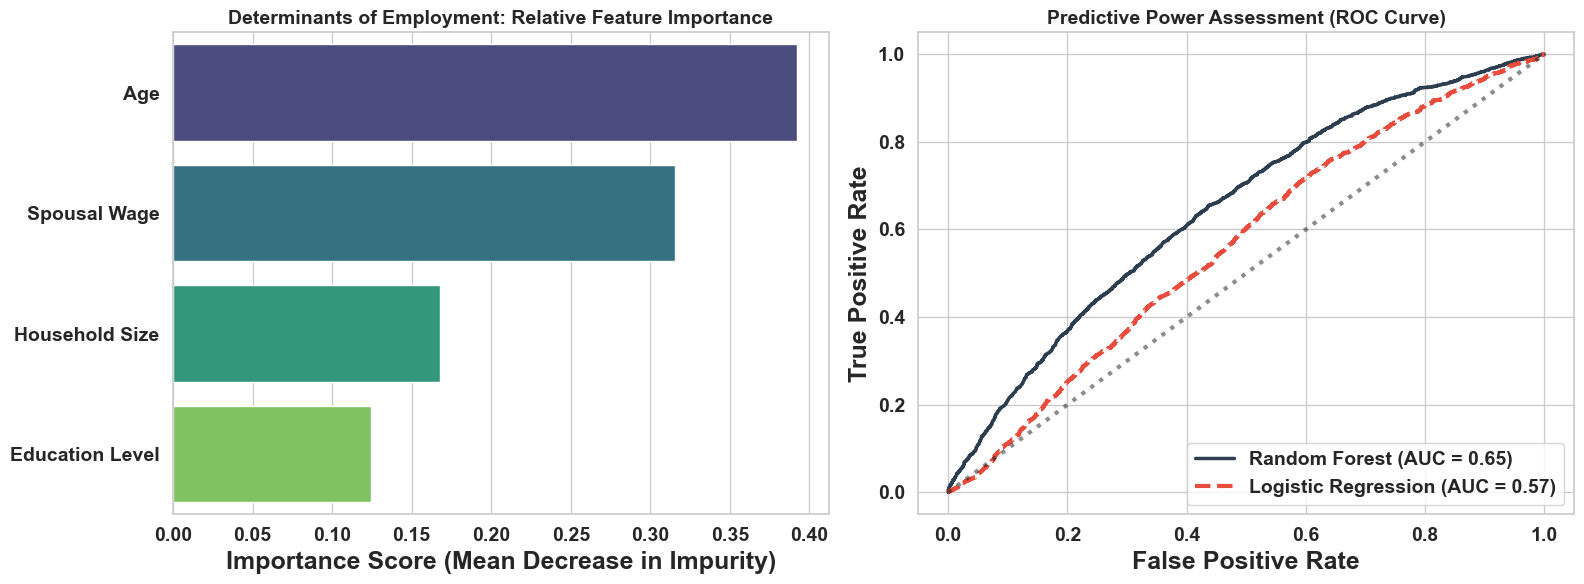


--- FACTOR IMPACT ANALYSIS (Logistic Regression Coefficients) ---
           Feature  Coefficient
0              Age     0.163852
3  Education Level     0.129313
2     Spousal Wage    -0.147038
1   Household Size    -0.149853

Interpretation: Positive values increase employment likelihood; Negative values decrease it.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- 1. DATA PREPARATION ---

# Select relevant features for prediction
# We exclude 'total_wage' as it is a result of employment, not a predictor
features = ['age', 'hh_size', 'spousal_wage', 'Education_Group']
target = 'is_employed'

# Create a modeling dataframe to avoid SettingWithCopy warnings
df_model = df_target_final[features + [target]].copy()

# Encode Categorical Variable (Education)
# We use Label Encoding here to preserve the ordinal nature (Level 1 < Level 2 < Level 3)
le = LabelEncoder()
df_model['Education_Encoded'] = le.fit_transform(df_model['Education_Group'])

# Define X (Features) and y (Target)
X = df_model[['age', 'hh_size', 'spousal_wage', 'Education_Encoded']]
y = df_model[target]

# Split into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (Critical for Logistic Regression convergence and interpretation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. MODEL DEPLOYMENT ---

# A. Logistic Regression (The "Explainable" Model)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# B. Random Forest (The "Non-Linear" Model)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train) # Tree models don't strictly need scaling

# --- 3. PERFORMANCE EVALUATION ---

# Generate Predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Print Professional Performance Summary
print("--- MODEL PERFORMANCE SUMMARY ---\n")
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_prob_log):.3f}")
print(f"Random Forest ROC-AUC:       {roc_auc_score(y_test, y_prob_rf):.3f}")
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

# --- 4. VISUALIZATION: KEY DRIVERS & MODEL COMPARISON ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Feature Importance (Random Forest)
# This shows WHICH factors matter most
importances = rf_model.feature_importances_
feature_names = ['Age', 'Household Size', 'Spousal Wage', 'Education Level']
indices = np.argsort(importances)[::-1]

sns.barplot(
    x=[importances[i] for i in indices], 
    y=[feature_names[i] for i in indices],
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("Determinants of Employment: Relative Feature Importance", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Importance Score (Mean Decrease in Impurity)")

# Plot B: ROC Curve (Model Comparison)
# This shows how well we separate "Working" vs "Not Working"
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

axes[1].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})", color="#2c3e50", linewidth=2.5)
axes[1].plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.2f})", color="#e74c3c", linestyle="--")
axes[1].plot([0, 1], [0, 1], 'k:', alpha=0.5) # Random guess line

axes[1].set_title("Predictive Power Assessment (ROC Curve)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# --- 5. INTERPRETATION: LOGISTIC COEFFICIENTS ---
# Extract and print coefficients to see Directionality (Positive vs Negative impact)
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n--- FACTOR IMPACT ANALYSIS (Logistic Regression Coefficients) ---")
print(coefs)
print("\nInterpretation: Positive values increase employment likelihood; Negative values decrease it.")

--- TASK 1: EMPLOYMENT PREDICTION (CLASSIFICATION) ---

Random Forest AUC:       0.6469
Gradient Boosting AUC:   0.6541 (Winner for Accuracy)

--- TASK 2: WAGE PREDICTION (REGRESSION) ---

Model R² (Explained Variance): 0.4107
RMSE (Avg Error in ₹):         ₹14771.64


C:\Users\shubh\AppData\Local\Temp\ipykernel_1528\3125465743.py:87: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




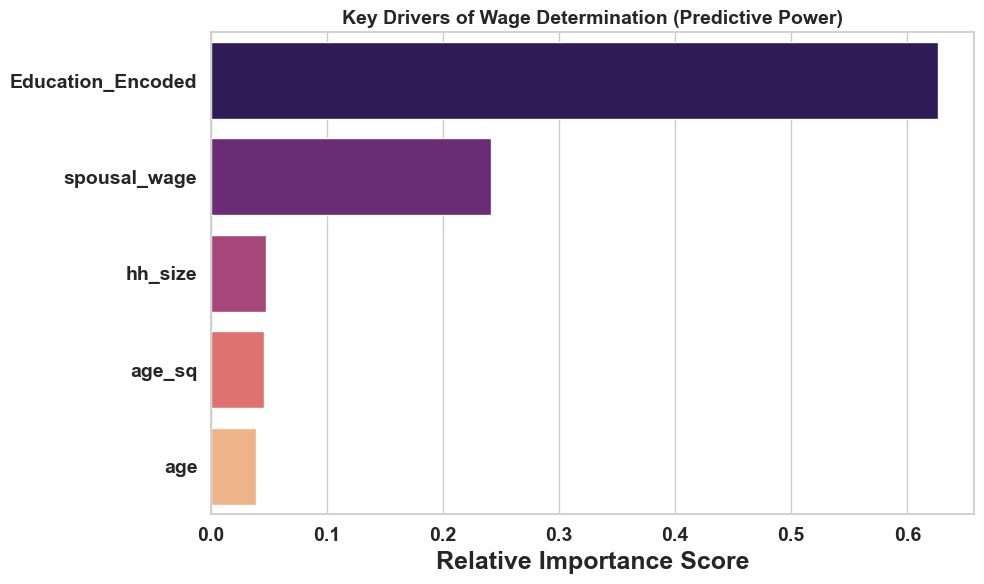

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# --- 1. DATA PREPARATION ---

# A. Encoding
le = LabelEncoder()
# Create a safe copy
df_ml = df_target_final.copy()
df_ml['Education_Encoded'] = le.fit_transform(df_ml['Education_Group'])

# Feature Selection
# We add 'Age_Squared' to capture the non-linear "U-shape" of life cycle
df_ml['age_sq'] = df_ml['age'] ** 2
features = ['age', 'age_sq', 'hh_size', 'spousal_wage', 'Education_Encoded']

# --- 2. CLASSIFICATION TASK: PREDICTING EMPLOYMENT (0 or 1) ---
print("--- TASK 1: EMPLOYMENT PREDICTION (CLASSIFICATION) ---\n")

X_cls = df_ml[features]
y_cls = df_ml['is_employed']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Model 1: Random Forest (Baseline)
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_cls.fit(X_train_c, y_train_c)

# Model 2: Gradient Boosting (Max Prediction)
gb_cls = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
gb_cls.fit(X_train_c, y_train_c)

# Evaluation
auc_rf = roc_auc_score(y_test_c, rf_cls.predict_proba(X_test_c)[:, 1])
auc_gb = roc_auc_score(y_test_c, gb_cls.predict_proba(X_test_c)[:, 1])

print(f"Random Forest AUC:       {auc_rf:.4f}")
print(f"Gradient Boosting AUC:   {auc_gb:.4f} (Winner for Accuracy)")


# --- 3. REGRESSION TASK: PREDICTING WAGES (Continuous ₹) ---
print("\n--- TASK 2: WAGE PREDICTION (REGRESSION) ---\n")

# Filter: We only predict wages for those who actually work (Wage > 0)
# (Predicting wage for non-workers is theoretically complex due to 'reservation wage' bias)
df_wage = df_ml[df_ml['total_wage'] > 0].copy()

X_reg = df_wage[features]
y_reg = df_wage['total_wage']

# Log-transform target to normalize distribution (Wages are usually right-skewed)
y_reg_log = np.log1p(y_reg)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg_log, test_size=0.2, random_state=42)

# Model: Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gb_reg.fit(X_train_r, y_train_r)

# Predictions (Reverse log transform to get actual Rupee values)
y_pred_log = gb_reg.predict(X_test_r)
y_pred_inr = np.expm1(y_pred_log)
y_actual_inr = np.expm1(y_test_r)

# Metrics
r2 = r2_score(y_test_r, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_actual_inr, y_pred_inr))

print(f"Model R² (Explained Variance): {r2:.4f}")
print(f"RMSE (Avg Error in ₹):         ₹{rmse:.2f}")


# --- 4. VISUALIZATION: WHAT DRIVES WAGES? ---
plt.figure(figsize=(10, 6))

# Extract Feature Importance from Wage Model
importances = gb_reg.feature_importances_
feature_names = features
indices = np.argsort(importances)[::-1]

sns.barplot(
    x=[importances[i] for i in indices], 
    y=[feature_names[i] for i in indices],
    palette="magma"
)

plt.title("Key Drivers of Wage Determination (Predictive Power)", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance Score")
plt.tight_layout()
plt.show()

In [25]:
import plotly.graph_objects as go
import plotly.express as px

# Map technical names to clean labels
clean_map = {
    'age': 'Age',
    'age_sq': 'Age Squared',
    'hh_size': 'Household Size',
    'spousal_wage': 'Spousal Wage',
    'Education_Encoded': 'Education Level'
}

# Data Prep - ensures no IndexError
importances_cls = gb_cls.feature_importances_
labels_cls = [clean_map.get(f, f) for f in X_cls.columns]
idx_cls = np.argsort(importances_cls)

# UI Construction
fig1 = go.Figure(go.Bar(
    x=[importances_cls[i] for i in idx_cls],
    y=[labels_cls[i] for i in idx_cls],
    orientation='h',
    marker=dict(
        color=px.colors.qualitative.Prism, # Multi-color bars
        line=dict(color='#FFFFFF', width=1)
    )
))

fig1.update_layout(
    title="<b>DETERMINANTS OF EMPLOYMENT (CLASSIFICATION)</b>",
    title_font=dict(size=20, color="white"),
    xaxis=dict(title="Importance Score", gridcolor='rgba(255,255,255,0.1)', color="white"),
    yaxis=dict(color="white"),
    paper_bgcolor='rgba(0,0,0,0)', # TRANSPARENT
    plot_bgcolor='rgba(0,0,0,0)',  # TRANSPARENT
    margin=dict(l=150, r=50, t=80, b=50),
    height=450
)
fig1.show()

In [26]:
# Data Prep - ensures no IndexError
importances_reg = gb_reg.feature_importances_
labels_reg = [clean_map.get(f, f) for f in X_reg.columns]
idx_reg = np.argsort(importances_reg)

# Create a vibrant color gradient for the regression plot
colors_reg = px.colors.sample_colorscale("Viridis", [i/(len(idx_reg)-1) for i in range(len(idx_reg))])

fig2 = go.Figure(go.Bar(
    x=[importances_reg[i] for i in idx_reg],
    y=[labels_reg[i] for i in idx_reg],
    orientation='h',
    marker=dict(
        color=colors_reg, # Multi-color bars
        line=dict(color='#FFFFFF', width=1)
    )
))

fig2.update_layout(
    title="<b>KEY DRIVERS OF WAGE DETERMINATION (REGRESSION)</b>",
    title_font=dict(size=20, color="white"),
    xaxis=dict(title="Relative Importance Score", gridcolor='rgba(255,255,255,0.1)', color="white"),
    yaxis=dict(color="white"),
    paper_bgcolor='rgba(0,0,0,0)', # TRANSPARENT
    plot_bgcolor='rgba(0,0,0,0)',  # TRANSPARENT
    margin=dict(l=150, r=50, t=80, b=50),
    height=450
)
fig2.show()